In [1]:
!pip install -q tflite-model-maker
!sudo apt install libportaudio2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.3/577.3 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 36.8 MB/s eta 0:0

In [3]:
from google.colab import files
import tensorflow as tf
assert tf.__version__.startswith('2')
from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohammadnasir97","key":"11b17aab7228fc0b9eb5a18579442af1"}'}

In [6]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [7]:
!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset

 95% 197M/207M [00:02<00:00, 98.2MB/s]
100% 207M/207M [00:02<00:00, 96.7MB/s]


In [9]:
import zipfile
with zipfile.ZipFile('covid-face-mask-detection-dataset.zip','r') as zip_ref:
  zip_ref.extractall('covid-face-mask-detection-dataset')

In [10]:
traindata = DataLoader.from_folder('/content/covid-face-mask-detection-dataset/New Masks Dataset/Train')
testndata = DataLoader.from_folder('/content/covid-face-mask-detection-dataset/New Masks Dataset/Test')
valdata = DataLoader.from_folder('/content/covid-face-mask-detection-dataset/New Masks Dataset/Validation')

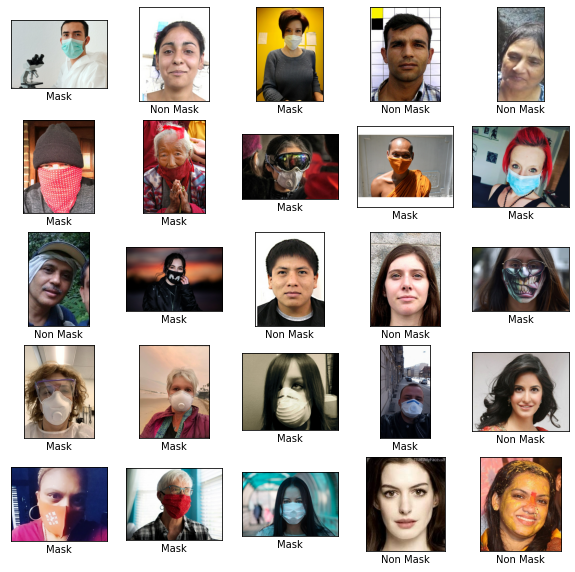

In [12]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(traindata.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(traindata.index_to_label[label.numpy()])
plt.show()


In [13]:
model = image_classifier.create(traindata,validation_data=valdata)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 3,415,586
Trainable params: 2,562
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5
18/18 [==============================] - 66s 4s/step - loss: 0.3487 - accuracy: 0.9375 - val_loss: 0.2978 - val_accuracy: 0.9412
Epoch 2/5
18/18 [==============================] - 61s 3s/step - loss: 0.2512 - accuracy: 0.9896

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 3,415,586
Trainable params: 2,562
Non-trainable params: 3,413,024
_________________________________________________________________


In [15]:
loss , accuracy = model.evaluate(testndata)

4/4 [==============================] - 9s 1s/step - loss: 0.2726 - accuracy: 0.9600


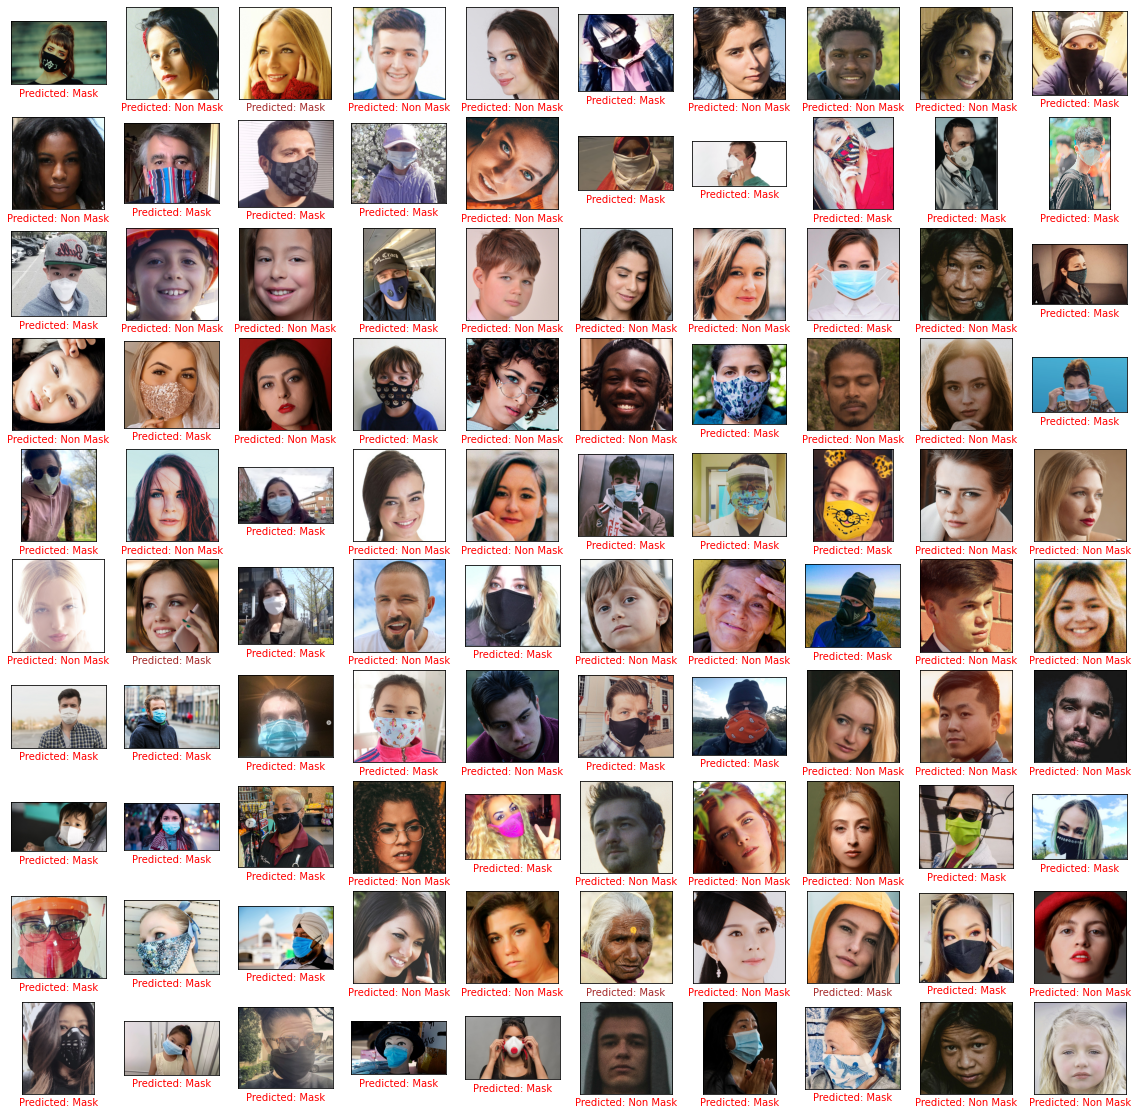

In [19]:
def get_mask_notmask(val1,val2):
  if val1 == val2:
    return 'red'
  else:
    return 'brown'
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(testndata)
for i, (image, label) in enumerate(testndata.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_mask_notmask(predict_label,
                          testndata.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()


In [20]:
config = QuantizationConfig.for_float16()

In [23]:
model.export(export_dir= '.',tflite_filename= 'model_fp16.tflite',label_filename='mask.txt',quantization_config= config)

In [28]:
model.export(export_dir='.',export_format=ExportFormat.LABEL)

In [27]:
model.evaluate_tflite('/content/model_fp16.tflite',testndata)

{'accuracy': 0.96}